# 基于深度学习的网络流量预测
本课题任务分为以下3部分：
* 网络流量数据集分析与可视化
* 训练循环神经网络，根据前n天的数据预测每个主机的预期流量
* 把预测结果与ctul数据进行比较，以猜测主机是否属于僵尸网络

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB']
plt.rcParams['axes.unicode_minus'] = False  # 坐标轴负数的负号显示

# 1、数据导入
导入数据并观察格式。
## 数据简介
计算机网络流量数据 - 一个约500K的CSV文件，其中包含过去一些真实网络流量数据的摘要。该数据集包含约21K行，涵盖了三个月内10个本地工作站IP的情况。这些本地IP中的一半在此期间的某个时刻被入侵，并成为了各种僵尸网络的成员。

## 内容

每一行都由四列组成：
* date: yyyy-mm-dd (从2006-07-01到2006-09-30)
* l_ipn: 本地IP（编码为0-9之间的整数，**每一个代表了一台本地主机**）
* r_asn: 远程ASN（一个整数，用于标识远程ISP， **每一个代表了一台远程主机**）
* f: 流量（该天的连接数）

**以该条数据为例：0	2006-07-01	0	701	1，其含义是：在2006-07-01日，本地的0号主机收到了来自远程701号的1个连接。**


<br> ps:
* ASN，全称为Autonomous System Number（自治系统号），是互联网中一种用于唯一标识和识别自治系统（AS）的数字标识符。自治系统是指一组网络和路由器，它们由单个组织或实体控制和管理，共同遵循相同的路由策略。ASN的作用是使互联网中的路由器能够识别和交换信息。

* 远程ISP，即远程Internet服务提供商，是指向广大用户综合提供互联网接入业务、信息业务、和增值业务的电信运营商。它是经国家主管部门批准的正式运营企业，享受国家法律保护。远程ISP主要为用户提供互联网接入服务，即通过电话线或其他传输方式将用户的计算机或其他终端设备连入Internet。除此之外，它还可能提供上网拨号、网上浏览、下载文件、收发电子邮件等服务。


In [4]:
df = pd.read_csv('cs448b_ipasn.csv')
df['date']= pd.to_datetime(df['date'])
df['date'] = df['date'].add(pd.DateOffset(years=15))  
df.head(10)

,date,l_ipn,r_asn,f
0,2021-07-01,0,701,1
1,2021-07-01,0,714,1
2,2021-07-01,0,1239,1
3,2021-07-01,0,1680,1
4,2021-07-01,0,2514,1
5,2021-07-01,0,3320,1
6,2021-07-01,0,3561,13
7,2021-07-01,0,4134,3
8,2021-07-01,0,5617,2
9,2021-07-01,0,6478,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20803 entries, 0 to 20802
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    20803 non-null  datetime64[ns]
 1   l_ipn   20803 non-null  int64         
 2   r_asn   20803 non-null  int64         
 3   f       20803 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 650.2 KB


In [6]:
df.describe()

,date,l_ipn,r_asn,f
count,20803,20803.000000,20803.000000,20803.000000
mean,2021-08-13 06:11:51.243570688,4.228236,12138.320338,93.914243
min,2021-07-01 00:00:00,0.000000,3.000000,1.000000
25%,2021-07-23 00:00:00,1.000000,4323.000000,1.000000
50%,2021-08-11 00:00:00,4.000000,8764.000000,2.000000
75%,2021-09-04 00:00:00,7.000000,17676.000000,8.000000
max,2021-09-30 00:00:00,9.000000,40092.000000,784234.000000
std,NaN,3.278183,9766.324252,5764.995269


# 2、数据预处理与可视化
* 按照时间、本地IP进行分组、求和，即可得到如下的数据。该数据表示每台主机在某一天共收到了多少流量。
* 根据date，生成两个新的列——yday（该日是该年的第几天）

In [8]:
df = df.groupby(['date','l_ipn'],as_index=False).sum()
df['yday'] = df['date'].dt.dayofyear
df['wday'] = df['date'].dt.dayofweek

In [9]:
df.head(10)

,date,l_ipn,r_asn,f,yday,wday
0,2021-07-01,0,436704,106,182,3
1,2021-07-01,1,182194,640,182,3
2,2021-07-01,2,212966,1677,182,3
3,2021-07-01,3,96376,22,182,3
4,2021-07-01,4,120507,184,182,3
5,2021-07-01,5,125647,44,182,3
6,2021-07-01,6,117227,63,182,3
7,2021-07-01,7,479524,411,182,3
8,2021-07-01,8,339609,448,182,3
9,2021-07-01,9,407669,1463,182,3


## 按照本地IP将数据分为10组

In [11]:
ip0 = df[df['l_ipn']==0]
max0 = np.max(ip0['f'])
ip1 = df[df['l_ipn']==1]
max1 = np.max(ip1['f'])
ip2 = df[df['l_ipn']==2]
max2 = np.max(ip2['f'])
ip3 = df[df['l_ipn']==3]
max3 = np.max(ip3['f'])
ip4 = df[df['l_ipn']==4]
max4 = np.max(ip4['f'])
ip5 = df[df['l_ipn']==5]
max5 = np.max(ip5['f'])
ip6 = df[df['l_ipn']==6]
max6 = np.max(ip6['f'])
ip7 = df[df['l_ipn']==7]
max7 = np.max(ip7['f'])
ip8 = df[df['l_ipn']==8]
max8 = np.max(ip8['f'])
ip9 = df[df['l_ipn']==9]
max9 = np.max(ip9['f'])
ip0.head(10)

,date,l_ipn,r_asn,f,yday,wday
0,2021-07-01,0,436704,106,182,3
10,2021-07-02,0,460025,920,183,4
20,2021-07-03,0,436624,249,184,5
30,2021-07-04,0,499290,2971,185,6
40,2021-07-05,0,423638,158,186,0
50,2021-07-06,0,601434,184,187,1
60,2021-07-07,0,574537,197,188,2
70,2021-07-08,0,442557,361,189,3
80,2021-07-09,0,370871,68,190,4
90,2021-07-10,0,572877,258,191,5


In [12]:
count, division = np.histogram(ip0['f'],bins=10)
division

array([  68.,  810., 1552., 2294., 3036., 3778., 4520., 5262., 6004.,
       6746., 7488.])

## 绘制10台主机每日流量的分布直方图

In [14]:
import pandas as pd  
import numpy as np  
  
def process1(series, min_percent=5, max_percent=80):  
    if series.dtype != 'float64':  
        raise ValueError("Input series must be of type float64.")  
      
    random_factors = 1 + (np.random.rand(len(series)) * (max_percent - min_percent) / 100 + min_percent / 100)  

    varied_series = series * random_factors  
      
    return varied_series  

Text(0.5, 1.0, 'Local IP 9 Flow')

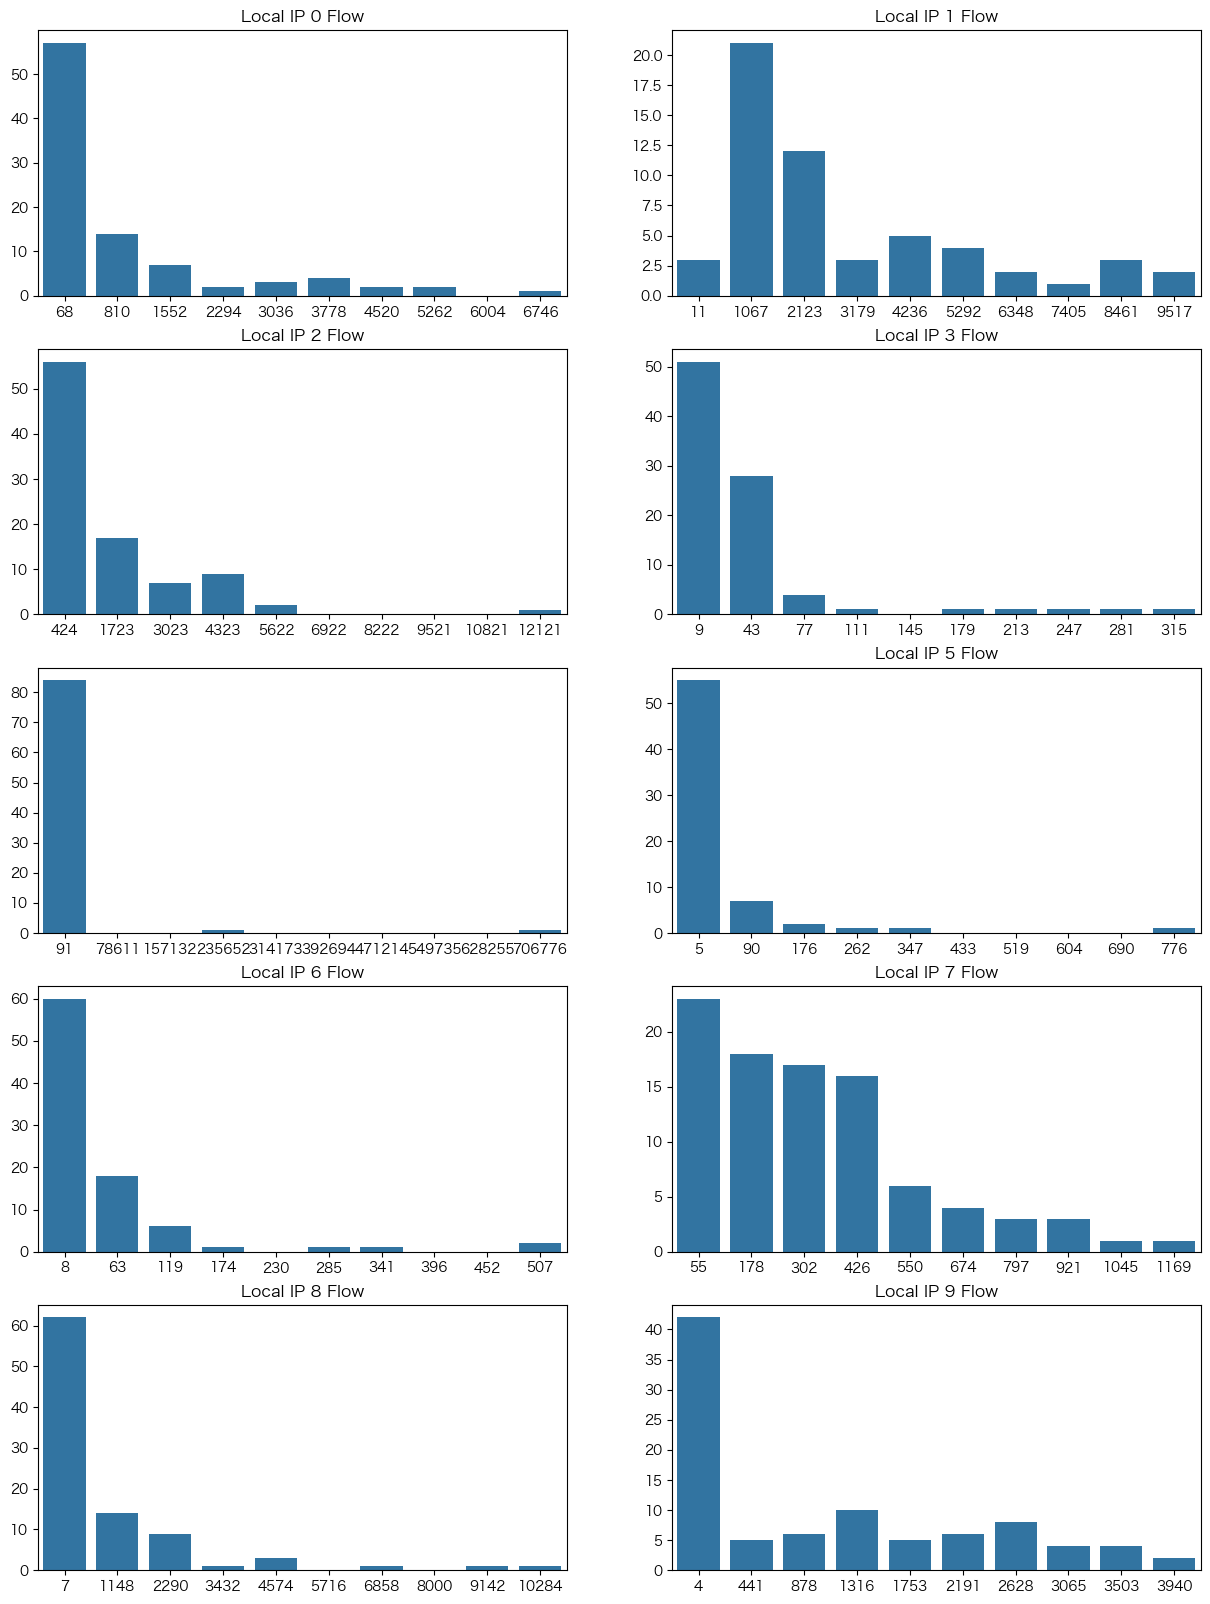

In [15]:
f,axarray = plt.subplots(5,2,figsize=(15,20))

count, division = np.histogram(ip0['f'],bins=10)
division = division.astype(np.int64)
g = sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[0,0])
axarray[0,0].set_title("Local IP 0 Flow")

count, division = np.histogram(ip1['f'],bins=10)
division = division.astype(np.int64)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[0,1])
axarray[0,1].set_title("Local IP 1 Flow")

count, division = np.histogram(ip2['f'],bins=10)
division = division.astype(np.int64)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[1,0])
axarray[1,0].set_title("Local IP 2 Flow")

count, division = np.histogram(ip3['f'],bins=10)
division = division.astype(np.int64)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[1,1])
axarray[1,1].set_title("Local IP 3 Flow")

count, division = np.histogram(ip4['f'],bins=10)
division = division.astype(np.int64)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[2,0])
axarray[2,1].set_title("Local IP 4 Flow")

count, division = np.histogram(ip5['f'],bins=10)
division = division.astype(np.int64)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[2,1])
axarray[2,1].set_title("Local IP 5 Flow")

count, division = np.histogram(ip6['f'],bins=10)
division = division.astype(np.int64)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[3,0])
axarray[3,0].set_title("Local IP 6 Flow")

count, division = np.histogram(ip7['f'],bins=10)
division = division.astype(np.int64)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[3,1])
axarray[3,1].set_title("Local IP 7 Flow")

count, division = np.histogram(ip8['f'],bins=10)
division = division.astype(np.int64)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[4,0])
axarray[4,0].set_title("Local IP 8 Flow")

count, division = np.histogram(ip9['f'],bins=10)
division = division.astype(np.int64)
sns.barplot(x=division[0:len(division)-1],y=count,ax=axarray[4,1])
axarray[4,1].set_title("Local IP 9 Flow")



## 10台主机流量随时间变化的折线图

**蓝色为流量变化趋势，绿色线为均值+3倍标准差，即正态分布中正常值的范围。可以理解为在此线以下的值大概率为正常值，以上则有可能为异常值。**

均值（mean）和标准差（standard deviation）是统计学中常用的两个概念。

均值是所有数值的总和除以数值的数量，它描述了数据集的“中心”或“平均”值。

标准差则描述了数据集中数值与均值的离散程度。它是每个数值与均值之差的平方的平均值的平方根。

“均值+3倍标准差”是一个常用的统计界限，用于识别可能的异常值或极端值。具体来说，如果一个数值大于均值加上3倍的标准差，那么这个数值通常被认为是异常高的。

这个界限基于一个假设，即数据大致呈正态分布（也称为钟形曲线分布）。在这种情况下，大约99.7%的数据值将位于均值加减3倍标准差的范围内。因此，超出这个范围的数值相对较少，可能被视为异常值。


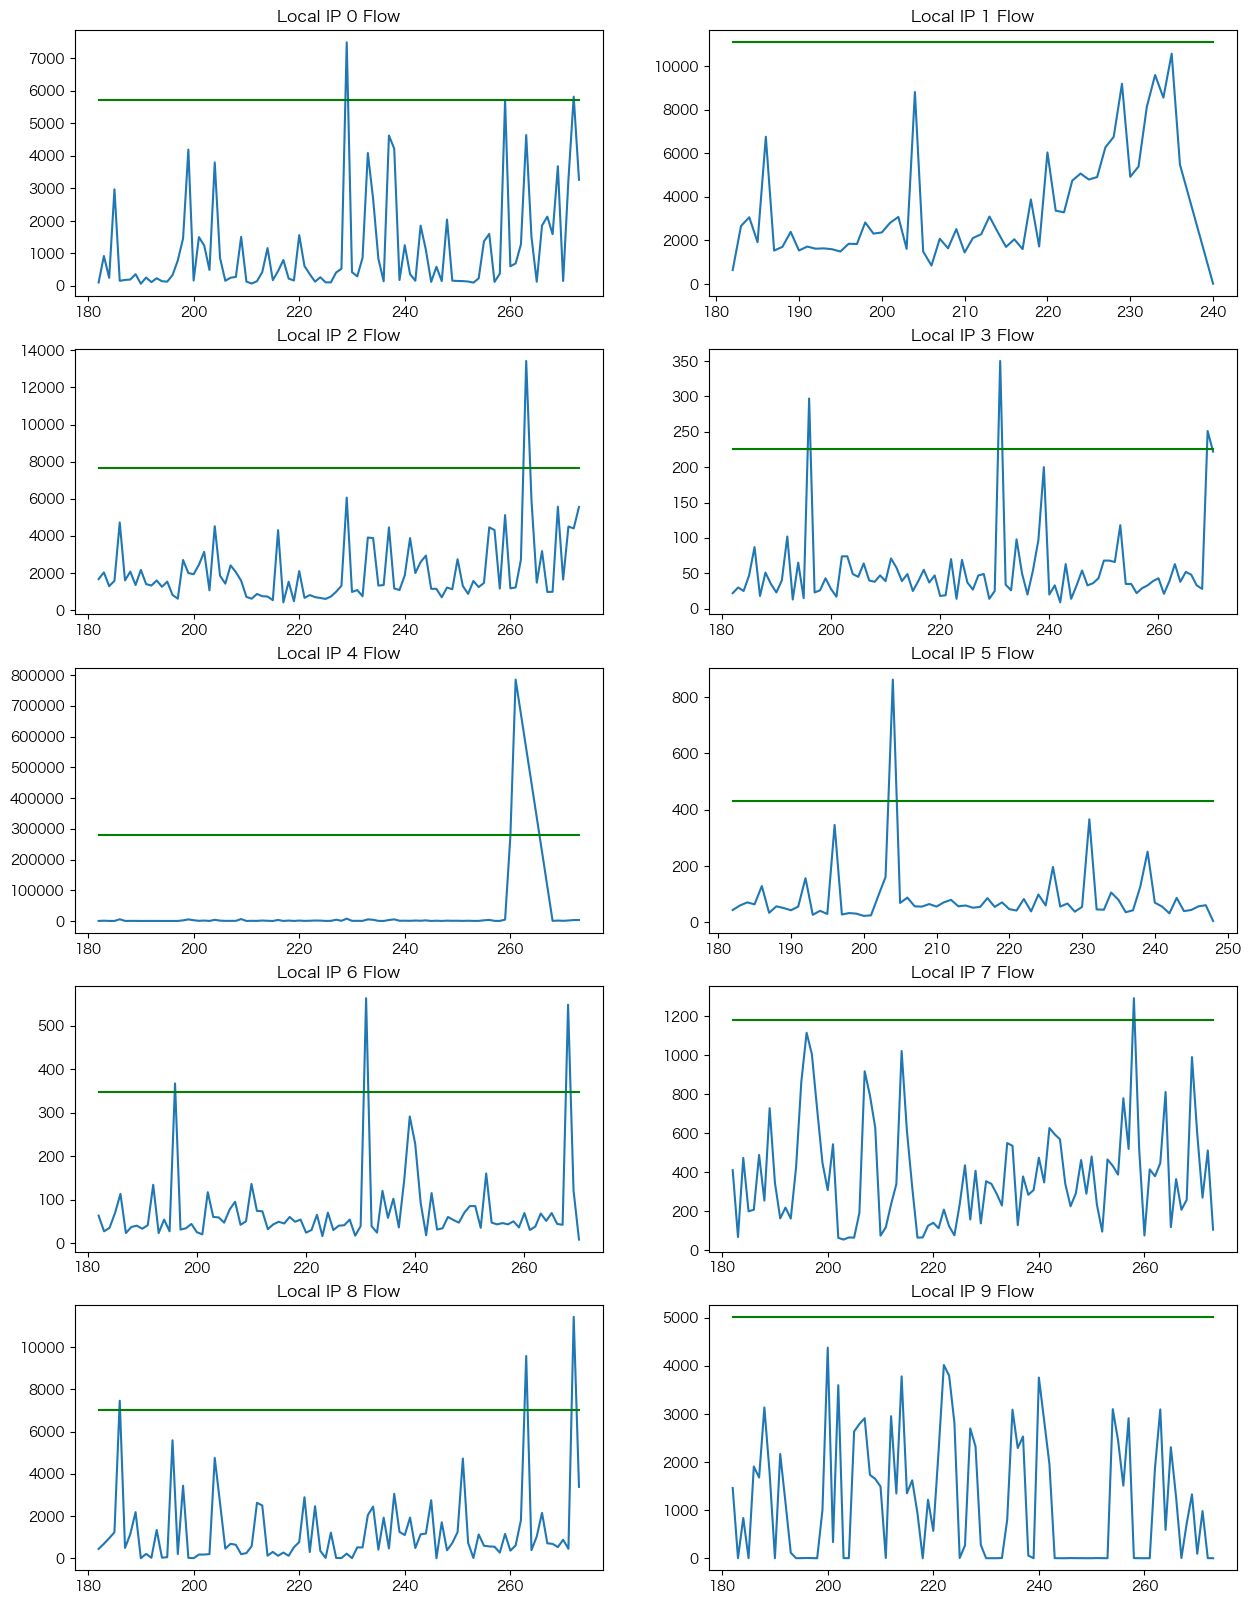

In [17]:
f,axarray = plt.subplots(5,2,figsize=(15,20))
axarray[0,0].plot(ip0['yday'],ip0['f'])
axarray[0,0].plot(ip0['yday'], [ip0['f'].mean() + 3*ip0['f'].std()]*len(ip0['yday']),color='g')
axarray[0,0].set_title("Local IP 0 Flow")

axarray[0,1].plot(ip1['yday'], ip1['f'])
axarray[0,1].plot(ip1['yday'], [ip1['f'].mean() + 3*ip1['f'].std()]*len(ip1['yday']),color='g')
axarray[0,1].set_title("Local IP 1 Flow")

axarray[1,0].plot(ip2['yday'], ip2['f'])
axarray[1,0].set_title("Local IP 2 Flow")
axarray[1,0].plot(ip2['yday'], [ip2['f'].mean() + 3*ip2['f'].std(ddof=0)]*len(ip2['yday']),color='g')


axarray[1,1].plot(ip3['yday'], ip3['f'])
axarray[1,1].set_title("Local IP 3 Flow")
axarray[1,1].plot(ip3['yday'], [ip3['f'].mean() + 3*ip3['f'].std(ddof=0)]*len(ip3['yday']),color='g')


axarray[2,0].plot(ip4['yday'], ip4['f'])
axarray[2,0].set_title("Local IP 4 Flow")
axarray[2,0].plot(ip4['yday'], [ip4['f'].mean() + 3*ip4['f'].std(ddof=0)]*len(ip4['yday']),color='g')

axarray[2,1].plot(ip5['yday'], ip5['f'])
axarray[2,1].set_title("Local IP 5 Flow")
axarray[2,1].plot(ip5['yday'], [ip5['f'].mean() + 3*ip5['f'].std(ddof=0)]*len(ip5['yday']),color='g')

axarray[3,0].plot(ip6['yday'], ip6['f'])
axarray[3,0].set_title("Local IP 6 Flow")
axarray[3,0].plot(ip6['yday'], [ip6['f'].mean() + 3*ip6['f'].std(ddof=0)]*len(ip6['yday']),color='g')

axarray[3,1].plot(ip7['yday'], ip7['f'])
axarray[3,1].set_title("Local IP 7 Flow")
axarray[3,1].plot(ip7['yday'], [ip7['f'].mean() + 3*ip7['f'].std(ddof=0)]*len(ip7['yday']),color='g')

axarray[4,0].plot(ip8['yday'], ip8['f'])
axarray[4,0].set_title("Local IP 8 Flow")
axarray[4,0].plot(ip8['yday'], [ip8['f'].mean() + 3*ip8['f'].std(ddof=0)]*len(ip8['yday']),color='g')


axarray[4,1].plot(ip9['yday'], ip9['f'])
axarray[4,1].set_title("Local IP 9 Flow")
axarray[4,1].plot(ip9['yday'], [ip9['f'].mean() + 3*ip9['f'].std(ddof=0)]*len(ip9['yday']),color='g')


从图中可以看出，折线整体上正常，但是有部分异常点（尤其是IP4），导致折线图无法反映真实情况。因此我们将异常值消除。

## 将异常值清除后绘制折线图

In [20]:
 for i in range(5):
    ip0 = ip0[ip0['f'] <= (ip0['f'].mean() + 3*ip0['f'].std())]
    ip1 = ip1[ip1['f'] <= (ip1['f'].mean() + 3*ip1['f'].std())]
    ip2 = ip2[ip2['f'] <= (ip2['f'].mean() + 3*ip2['f'].std())]
    ip3 = ip3[ip3['f'] <= (ip3['f'].mean() + 3*ip3['f'].std())]
    ip4 = ip4[ip4['f'] <= (ip4['f'].mean() + 3*ip4['f'].std())]
    ip5 = ip5[ip5['f'] <= (ip5['f'].mean() + 3*ip5['f'].std())]
    ip6 = ip6[ip6['f'] <= (ip6['f'].mean() + 3*ip6['f'].std())]
    ip7 = ip7[ip7['f'] <= (ip7['f'].mean() + 3*ip7['f'].std())]
    ip8 = ip8[ip8['f'] <= (ip8['f'].mean() + 3*ip8['f'].std())]
    ip9 = ip9[ip9['f'] <= (ip9['f'].mean() + 3*ip9['f'].std())]

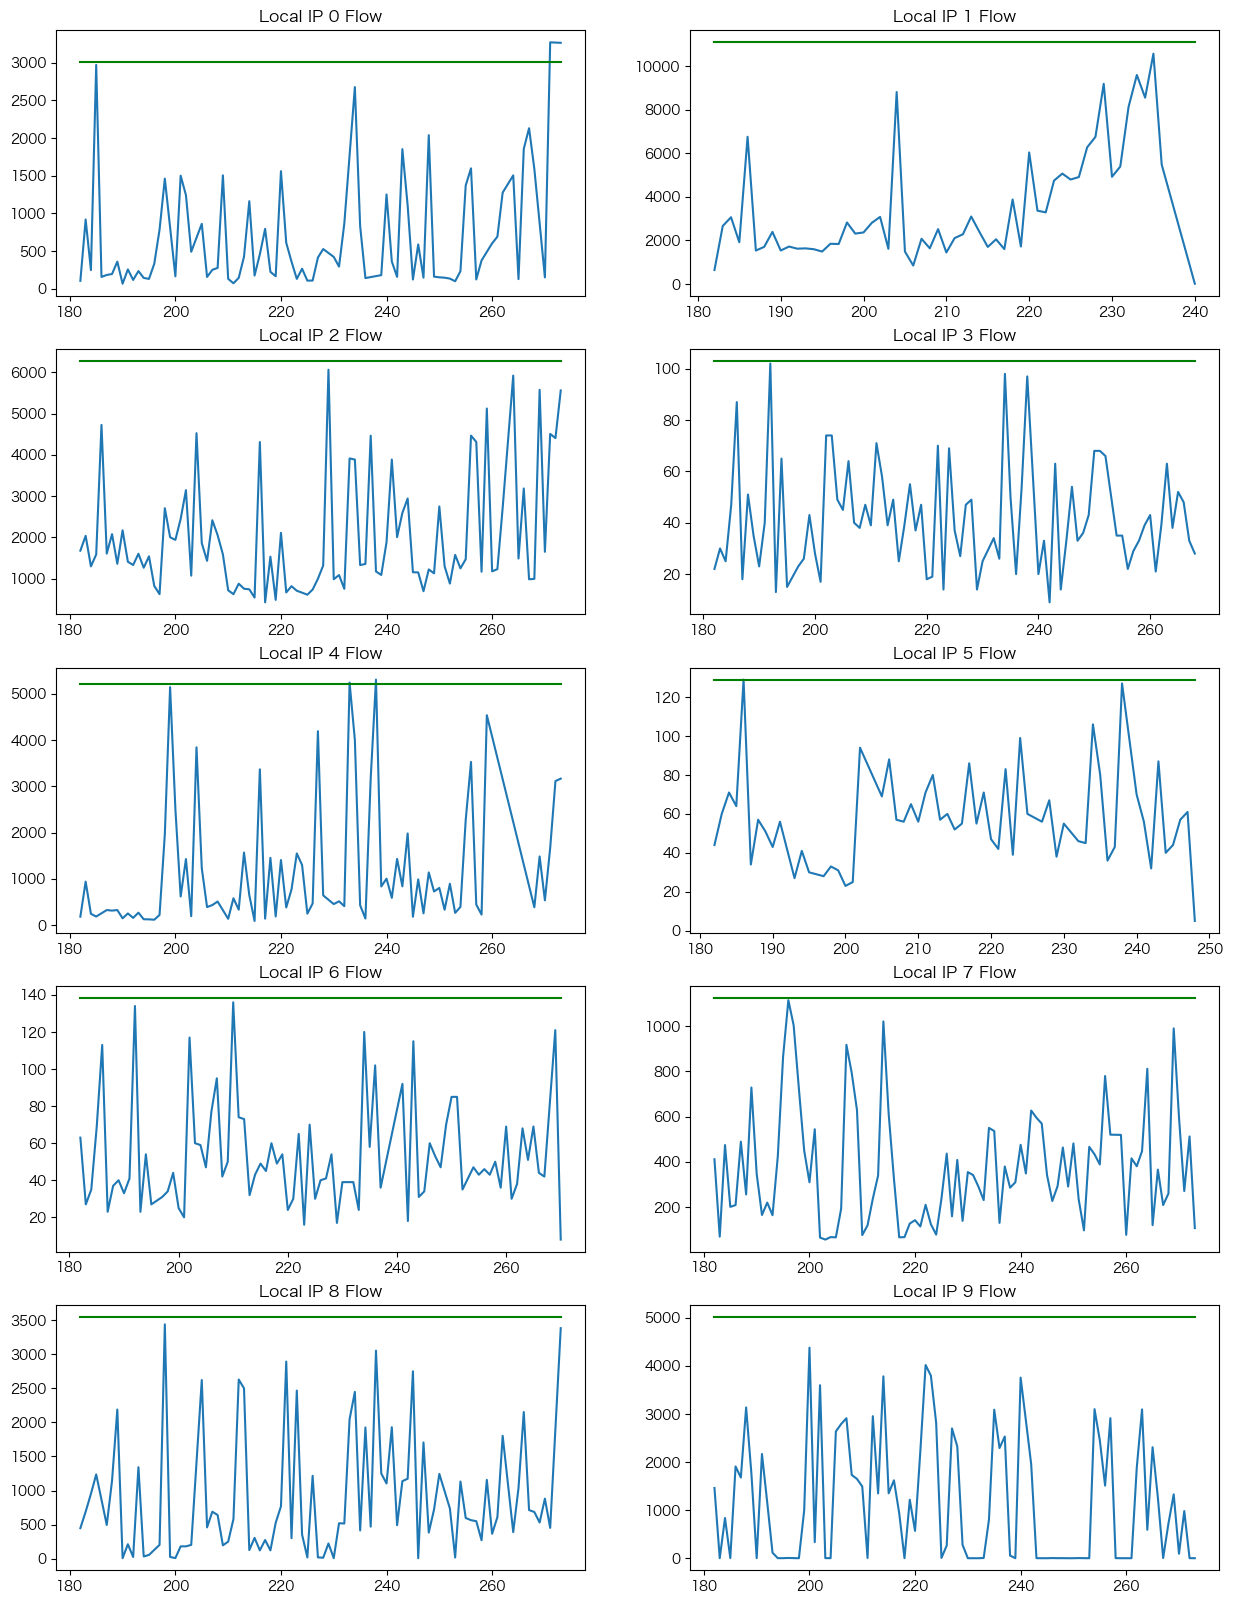

In [21]:
f,axarray = plt.subplots(5,2,figsize=(15,20))
axarray[0,0].plot(ip0['yday'],ip0['f'])
axarray[0,0].plot(ip0['yday'], [ip0['f'].mean() + 3*ip0['f'].std()]*len(ip0['yday']),color='g')
axarray[0,0].set_title("Local IP 0 Flow")

axarray[0,1].plot(ip1['yday'], ip1['f'])
axarray[0,1].plot(ip1['yday'], [ip1['f'].mean() + 3*ip1['f'].std()]*len(ip1['yday']),color='g')
axarray[0,1].set_title("Local IP 1 Flow")

axarray[1,0].plot(ip2['yday'], ip2['f'])
axarray[1,0].set_title("Local IP 2 Flow")
axarray[1,0].plot(ip2['yday'], [ip2['f'].mean() + 3*ip2['f'].std(ddof=0)]*len(ip2['yday']),color='g')


axarray[1,1].plot(ip3['yday'], ip3['f'])
axarray[1,1].set_title("Local IP 3 Flow")
axarray[1,1].plot(ip3['yday'], [ip3['f'].mean() + 3*ip3['f'].std(ddof=0)]*len(ip3['yday']),color='g')


axarray[2,0].plot(ip4['yday'], ip4['f'])
axarray[2,0].set_title("Local IP 4 Flow")
axarray[2,0].plot(ip4['yday'], [ip4['f'].mean() + 3*ip4['f'].std(ddof=0)]*len(ip4['yday']),color='g')

axarray[2,1].plot(ip5['yday'], ip5['f'])
axarray[2,1].set_title("Local IP 5 Flow")
axarray[2,1].plot(ip5['yday'], [ip5['f'].mean() + 3*ip5['f'].std(ddof=0)]*len(ip5['yday']),color='g')

axarray[3,0].plot(ip6['yday'], ip6['f'])
axarray[3,0].set_title("Local IP 6 Flow")
axarray[3,0].plot(ip6['yday'], [ip6['f'].mean() + 3*ip6['f'].std(ddof=0)]*len(ip6['yday']),color='g')

axarray[3,1].plot(ip7['yday'], ip7['f'])
axarray[3,1].set_title("Local IP 7 Flow")
axarray[3,1].plot(ip7['yday'], [ip7['f'].mean() + 3*ip7['f'].std(ddof=0)]*len(ip7['yday']),color='g')

axarray[4,0].plot(ip8['yday'], ip8['f'])
axarray[4,0].set_title("Local IP 8 Flow")
axarray[4,0].plot(ip8['yday'], [ip8['f'].mean() + 3*ip8['f'].std(ddof=0)]*len(ip8['yday']),color='g')


axarray[4,1].plot(ip9['yday'], ip9['f'])
axarray[4,1].set_title("Local IP 9 Flow")
axarray[4,1].plot(ip9['yday'], [ip9['f'].mean() + 3*ip9['f'].std(ddof=0)]*len(ip9['yday']),color='g')


## 绘制每天的流量总数（按weekday分组求和）

In [23]:
ip0 = ip0.drop('date', axis = 1)
ip1 = ip1.drop('date', axis = 1)
ip2 = ip2.drop('date', axis = 1)
ip3 = ip3.drop('date', axis = 1)
ip4 = ip4.drop('date', axis = 1)
ip5 = ip5.drop('date', axis = 1)
ip6 = ip6.drop('date', axis = 1)
ip7 = ip7.drop('date', axis = 1)
ip8 = ip8.drop('date', axis = 1)
ip9 = ip9.drop('date', axis = 1)

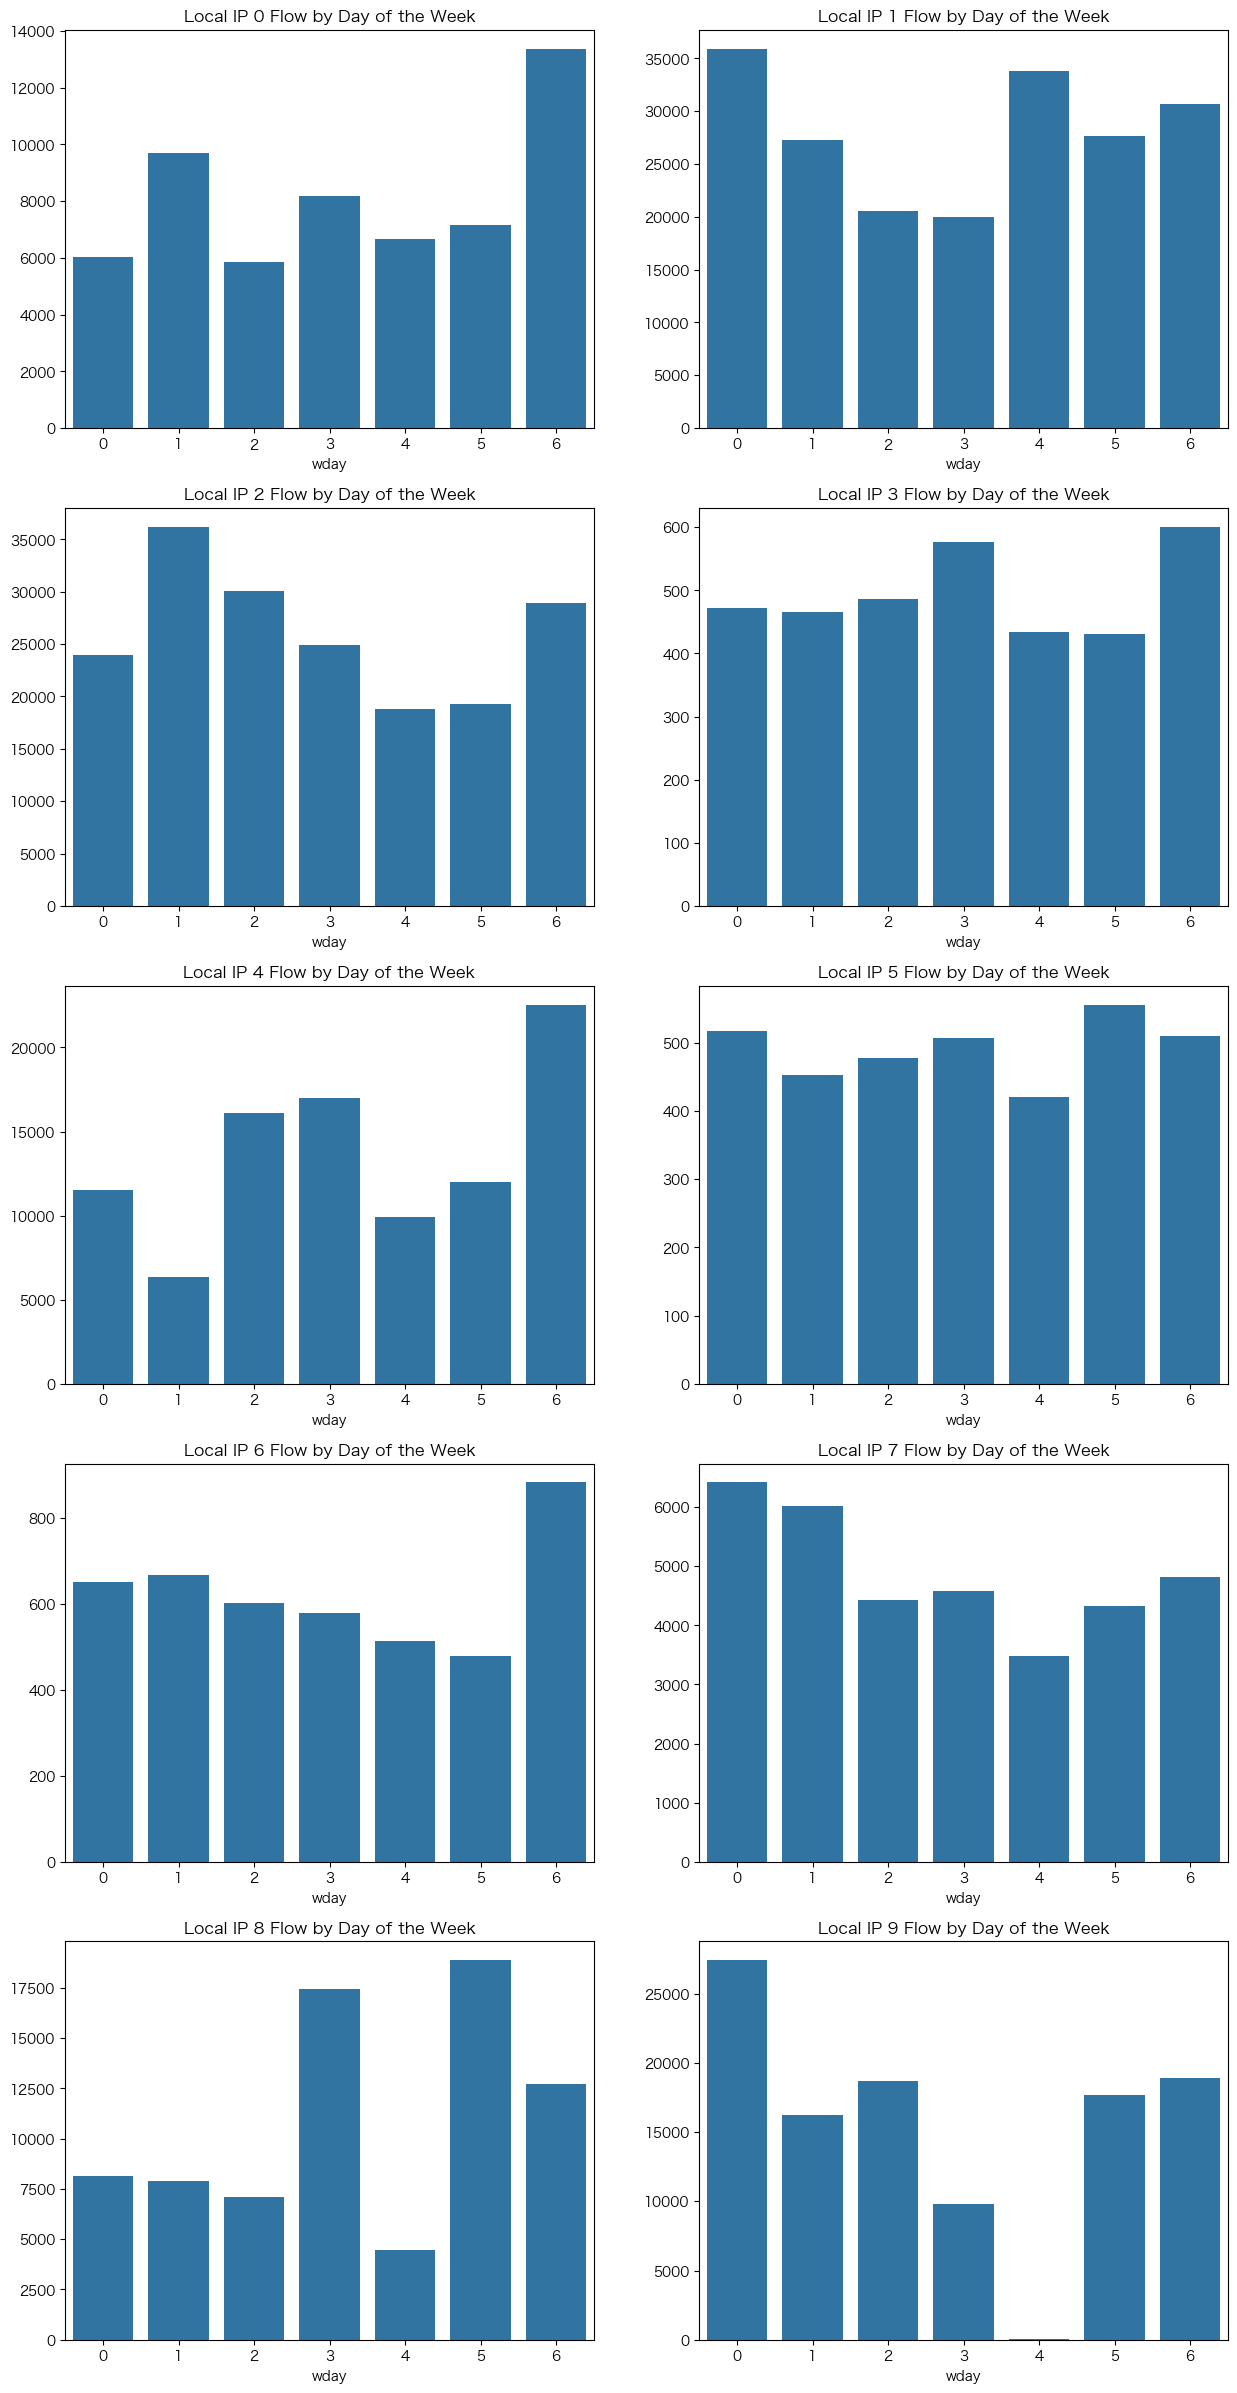

In [24]:
f,axarray = plt.subplots(5,2,figsize=(15,30))
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip0.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[0,0])
axarray[0,0].set_title("Local IP 0 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip1.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[0,1])
axarray[0,1].set_title("Local IP 1 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip2.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[1,0])
axarray[1,0].set_title("Local IP 2 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip3.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[1,1])
axarray[1,1].set_title("Local IP 3 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip4.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[2,0])
axarray[2,0].set_title("Local IP 4 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip5.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[2,1])
axarray[2,1].set_title("Local IP 5 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip6.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[3,0])
axarray[3,0].set_title("Local IP 6 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip7.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[3,1])
axarray[3,1].set_title("Local IP 7 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip8.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[4,0])
axarray[4,0].set_title("Local IP 8 Flow by Day of the Week")
sns.barplot(x= ip0.groupby('wday',as_index=False).sum()['wday'],y= ip9.groupby('wday',as_index=False).sum()['f'].values,ax=axarray[4,1])
axarray[4,1].set_title("Local IP 9 Flow by Day of the Week")

plt.show()

## 绘制10台主机的滚动趋势
rolling(3)：这是pandas的一个方法，用于计算**滚动统计**。在这里，它创建了一个滚动窗口，窗口大小为3。这意味着对于每一行，它都会考虑该行及其前两行（总共3行）来计算统计值。对于前两行，由于没有足够的数据，它们的结果会是NaN（表示“不是一个数字”）。
<br> <br> 
这段代码绘制了ip0 DataFrame中'f'列的滚动3点平均值的线图。这样的滚动平均图常常用于观察数据的变化趋势，特别是在时间序列分析中，它可以帮助识别数据的长期趋势或周期性变化。

Text(0.5, 1.0, 'Local IP 9 Rolling Flow by Day of the Week')

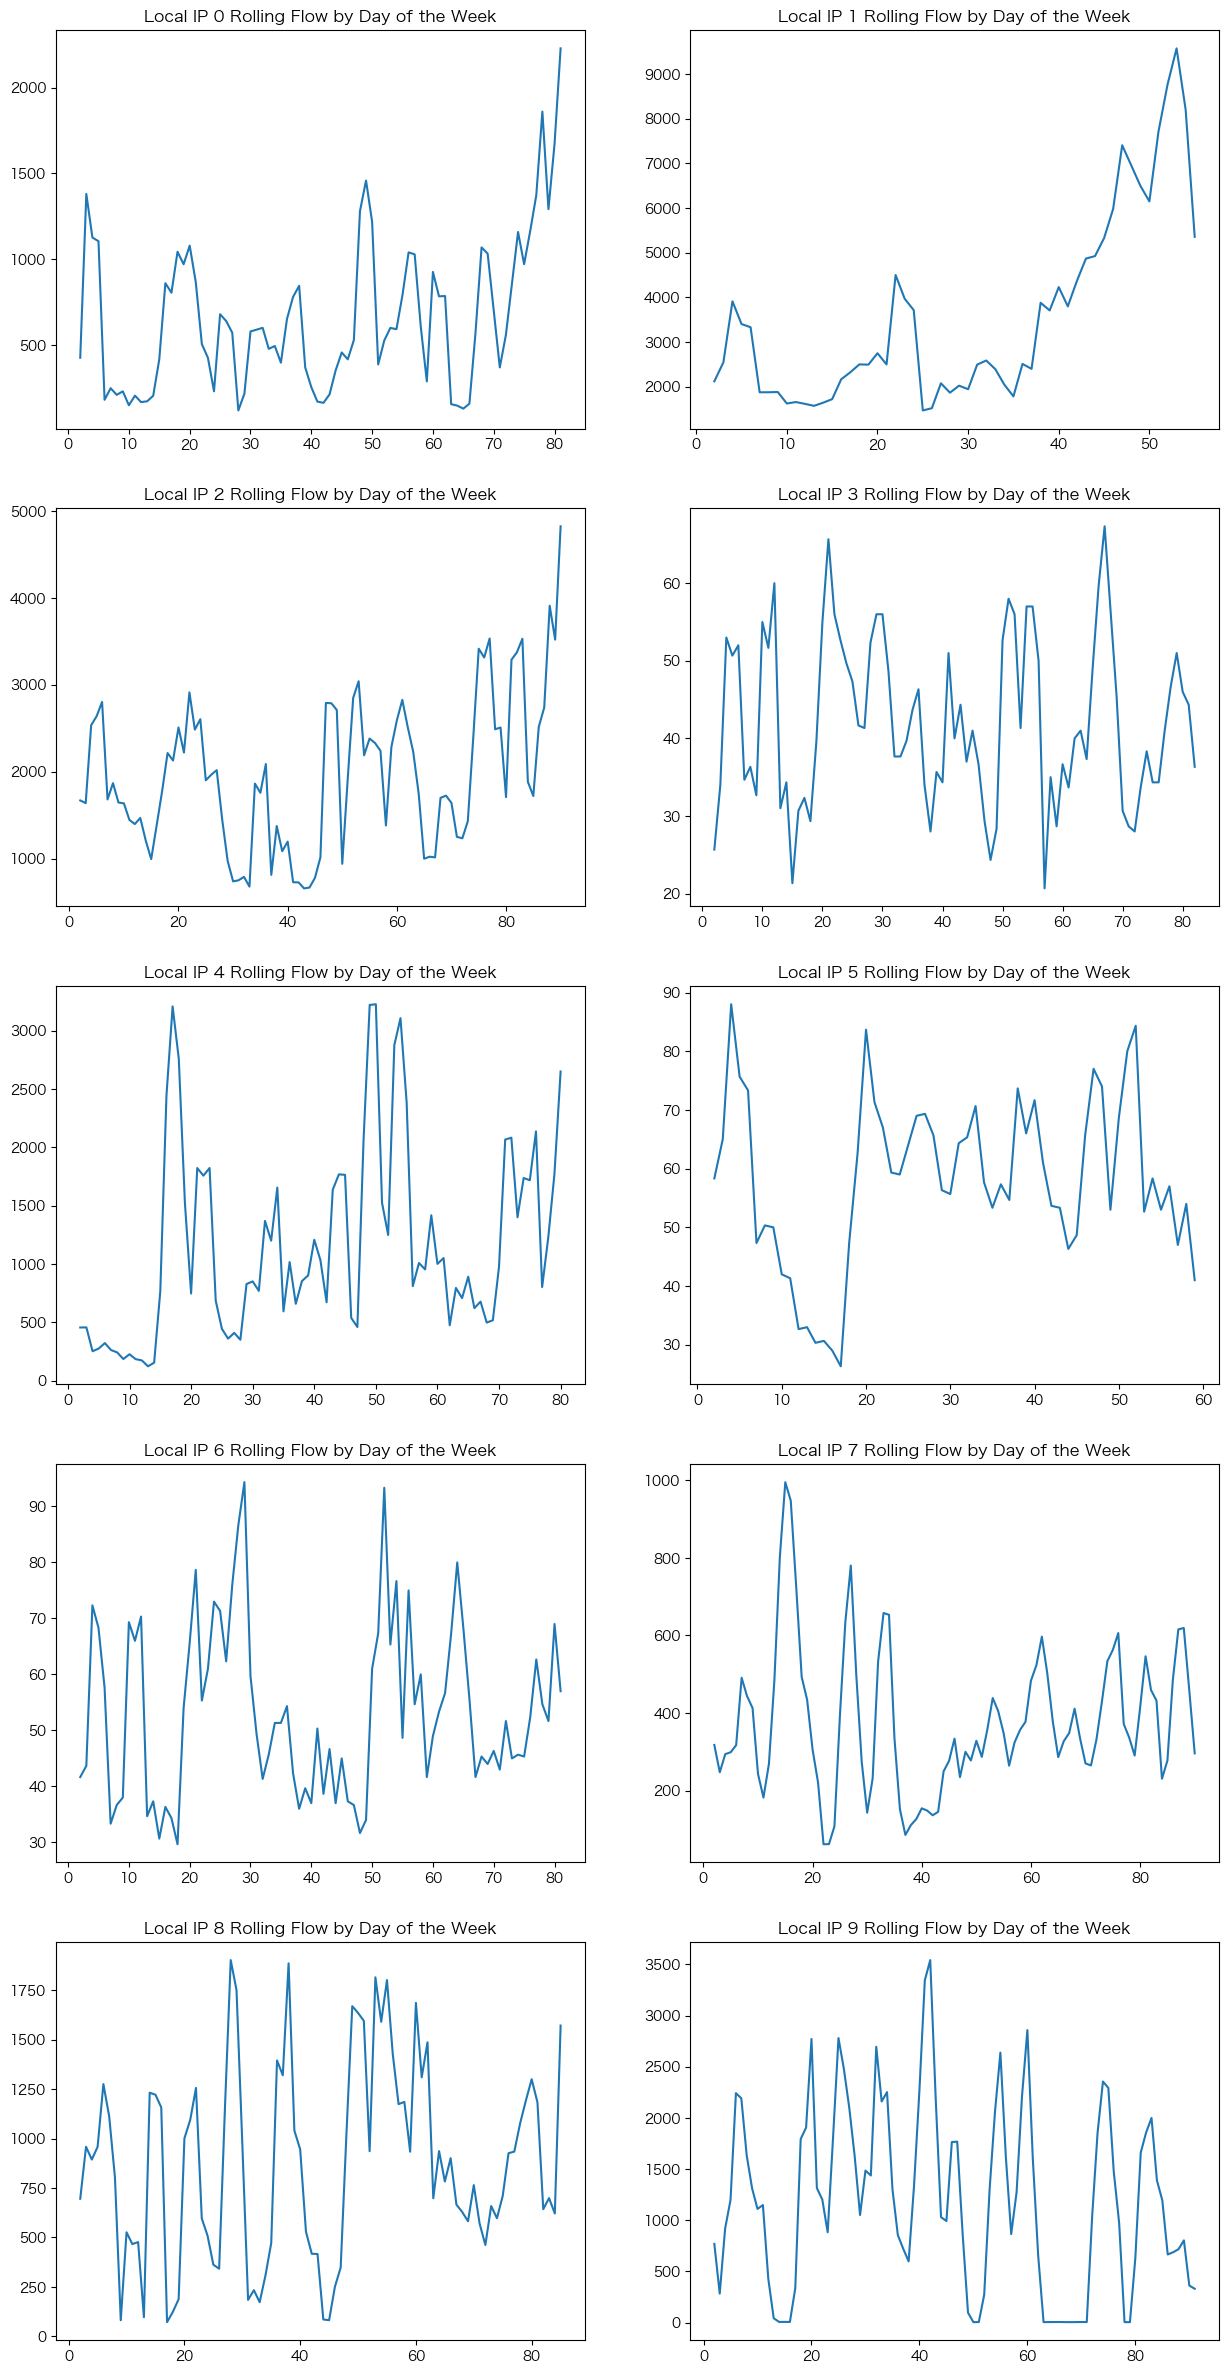

In [26]:
f,axarray = plt.subplots(5,2,figsize=(15,30))
axarray[0,0].plot(range(len(ip0['f'])),ip0['f'].rolling(3).mean())
axarray[0,0].set_title("Local IP 0 Rolling Flow by Day of the Week")
axarray[0,1].plot(range(len(ip1['f'])),ip1['f'].rolling(3).mean())
axarray[0,1].set_title("Local IP 1 Rolling Flow by Day of the Week")
axarray[1,0].plot(range(len(ip2['f'])),ip2['f'].rolling(3).mean())
axarray[1,0].set_title("Local IP 2 Rolling Flow by Day of the Week")
axarray[1,1].plot(range(len(ip3['f'])),ip3['f'].rolling(3).mean())
axarray[1,1].set_title("Local IP 3 Rolling Flow by Day of the Week")
axarray[2,0].plot(range(len(ip4['f'])),ip4['f'].rolling(3).mean())
axarray[2,0].set_title("Local IP 4 Rolling Flow by Day of the Week")
axarray[2,1].plot(range(len(ip5['f'])),ip5['f'].rolling(3).mean())
axarray[2,1].set_title("Local IP 5 Rolling Flow by Day of the Week")
axarray[3,0].plot(range(len(ip6['f'])),ip6['f'].rolling(3).mean())
axarray[3,0].set_title("Local IP 6 Rolling Flow by Day of the Week")
axarray[3,1].plot(range(len(ip7['f'])),ip7['f'].rolling(3).mean())
axarray[3,1].set_title("Local IP 7 Rolling Flow by Day of the Week")
axarray[4,0].plot(range(len(ip8['f'])),ip8['f'].rolling(3).mean())
axarray[4,0].set_title("Local IP 8 Rolling Flow by Day of the Week")
axarray[4,1].plot(range(len(ip9['f'])),ip9['f'].rolling(3).mean())
axarray[4,1].set_title("Local IP 9 Rolling Flow by Day of the Week")

# 3、基于RNN的流量预测

循环神经网络（Recurrent Neural Network） 是一种特殊的神经网络类型，其中的神经元连接形成了循环，使它们不仅依赖于当前的输入，还依赖于之前的 n 个输入。因此在预测序列时表现出色。

为了训练循环神经网络，我们创建一个特征数据集，其中每一行都包含之前 n 个观察值（lookback 变量）的序列，并配对一周中的某一天。目标值（y_train）是当前天需要预测的值。

In [29]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

循环神经网络在处理归一化数据时的表现更佳，因此我们将对10组流量数据进行归一化处理。

In [31]:
fv =[float(v)/float(max0) for v in ip0['f'].values]
ip0.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max1) for v in ip1['f'].values]
ip1.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max2) for v in ip2['f'].values]
ip2.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max3) for v in ip3['f'].values]
ip3.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max4) for v in ip4['f'].values]
ip4.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max5) for v in ip5['f'].values]
ip5.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max6) for v in ip6['f'].values]
ip6.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max7) for v in ip7['f'].values]
ip7.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max8) for v in ip8['f'].values]
ip8.loc[:,'f'] =np.array(fv).reshape(-1,1)
fv =[float(v)/float(max9) for v in ip9['f'].values]
ip9.loc[:,'f'] =np.array(fv).reshape(-1,1)  

In [32]:
ip0

,l_ipn,r_asn,f,yday,wday
0,0,436704,0.014156,182,3
10,0,460025,0.122863,183,4
20,0,436624,0.033253,184,5
30,0,499290,0.396768,185,6
40,0,423638,0.021100,186,0
...,...,...,...,...,...
798,0,420374,0.284589,267,4
805,0,421375,0.212473,268,5
821,0,696538,0.020299,270,0
829,0,545670,0.436699,271,1


**三个方法：**

* create_dataset：用于为我们的模型创建特征和目标的列表；
* trainModel：用于训练单个RNN；
* predictFlow：用于使用已训练的模型进行预测。

In [34]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)].values
        dataX.append(a)
        dataY.append(dataset['f'].iloc[i + look_back])
    return np.array(dataX), np.array(dataY)

In [35]:
from tensorflow.keras.layers import TimeDistributed
# from tensorflow.keras.constraints import nonneg
look_back = 14

def trainModel(data):
    data['f'] = data['f'].astype('float32')
    train = data[0:look_back*5].copy()
    trainX, trainY = create_dataset(train, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, 2))
    model = Sequential()
    model.add(LSTM(64,input_shape=(trainX.shape[1], trainX.shape[2]),
               return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=0)
    return model

In [36]:
def predictFlow(_model,data):
    ypred=[0]*look_back
    _max = np.max(data['f'])
    for k in range(len(data)-look_back):
        pattern = data[k:k+look_back].values
        x = np.reshape(pattern, (1, len(pattern), 2))
        ypred.append(_model.predict(x)[0][0])
    ypred=[v*_max for v in ypred]
    return ypred

## 对10个本地主机分别训练1个RNN
仅以0号主机为例输出训练日志，避免过于冗长

In [38]:
def trainModel0(data):
    data['f'] = data['f'].astype('float32')
    train = data[0:look_back*5].copy()
    trainX, trainY = create_dataset(train, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, 2))
    model = Sequential()
    model.add(LSTM(64,input_shape=(trainX.shape[1], trainX.shape[2]),
               return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    history = model.fit(trainX, trainY, epochs=100, batch_size=16)
    return model, history
m0, history = trainModel0(ip0[['f','wday']].copy())

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1319  
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0193 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079
Epoch 16/100
4/4 ━━━━━━━━━━━━━━

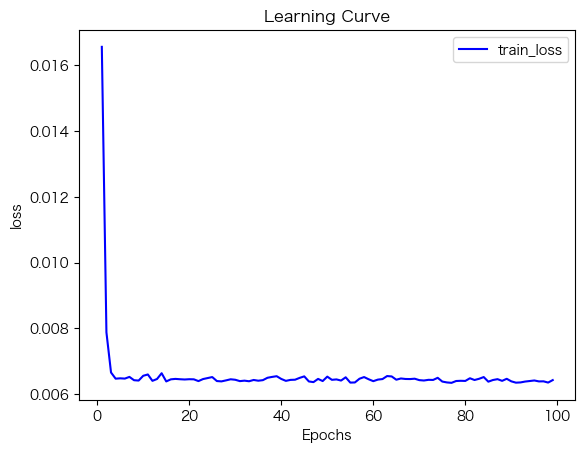

In [39]:
train_name = 'loss'
train = history.history[train_name][1:]
epochs = range(1, len(train)+1)
#Train and validation accuracy
plt.plot(epochs, train, 'b' , label = 'train_'+ train_name)
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel(train_name)
plt.legend()
plt.show()

## 划分训练测试集

In [41]:
def split(df):
    total_rows = len(df)  
    # 计算后50%的行数  
    half_rows = (total_rows // 10)*8
    last_half_rows = total_rows - half_rows  
    # 使用iloc来获取后20%的数据  
    return df.iloc[:half_rows].reset_index(drop=True)  , df.iloc[half_rows:].reset_index(drop=True)    

In [42]:
ip0_train, ip0_test = split(ip0[['f','wday']])
ip1_train, ip1_test = split(ip1[['f','wday']])
ip2_train, ip2_test = split(ip2[['f','wday']])
ip3_train, ip3_test = split(ip3[['f','wday']])
ip4_train, ip4_test = split(ip4[['f','wday']])
ip5_train, ip5_test = split(ip5[['f','wday']])
ip6_train, ip6_test = split(ip6[['f','wday']])
ip7_train, ip7_test = split(ip7[['f','wday']])
ip8_train, ip8_test = split(ip8[['f','wday']])
ip9_train, ip9_test = split(ip9[['f','wday']])

In [43]:
m0 = trainModel(ip1_train[['f','wday']].copy())
m1 = trainModel(ip1_train[['f','wday']].copy())
m2 = trainModel(ip2_train[['f','wday']].copy())
m3 = trainModel(ip3_train[['f','wday']].copy())
m4 = trainModel(ip4_train[['f','wday']].copy())
m5 = trainModel(ip5_train[['f','wday']].copy())
m6 = trainModel(ip6_train[['f','wday']].copy())
m7 = trainModel(ip7_train[['f','wday']].copy())
m8 = trainModel(ip8_train[['f','wday']].copy())
m9 = trainModel(ip9_train[['f','wday']].copy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

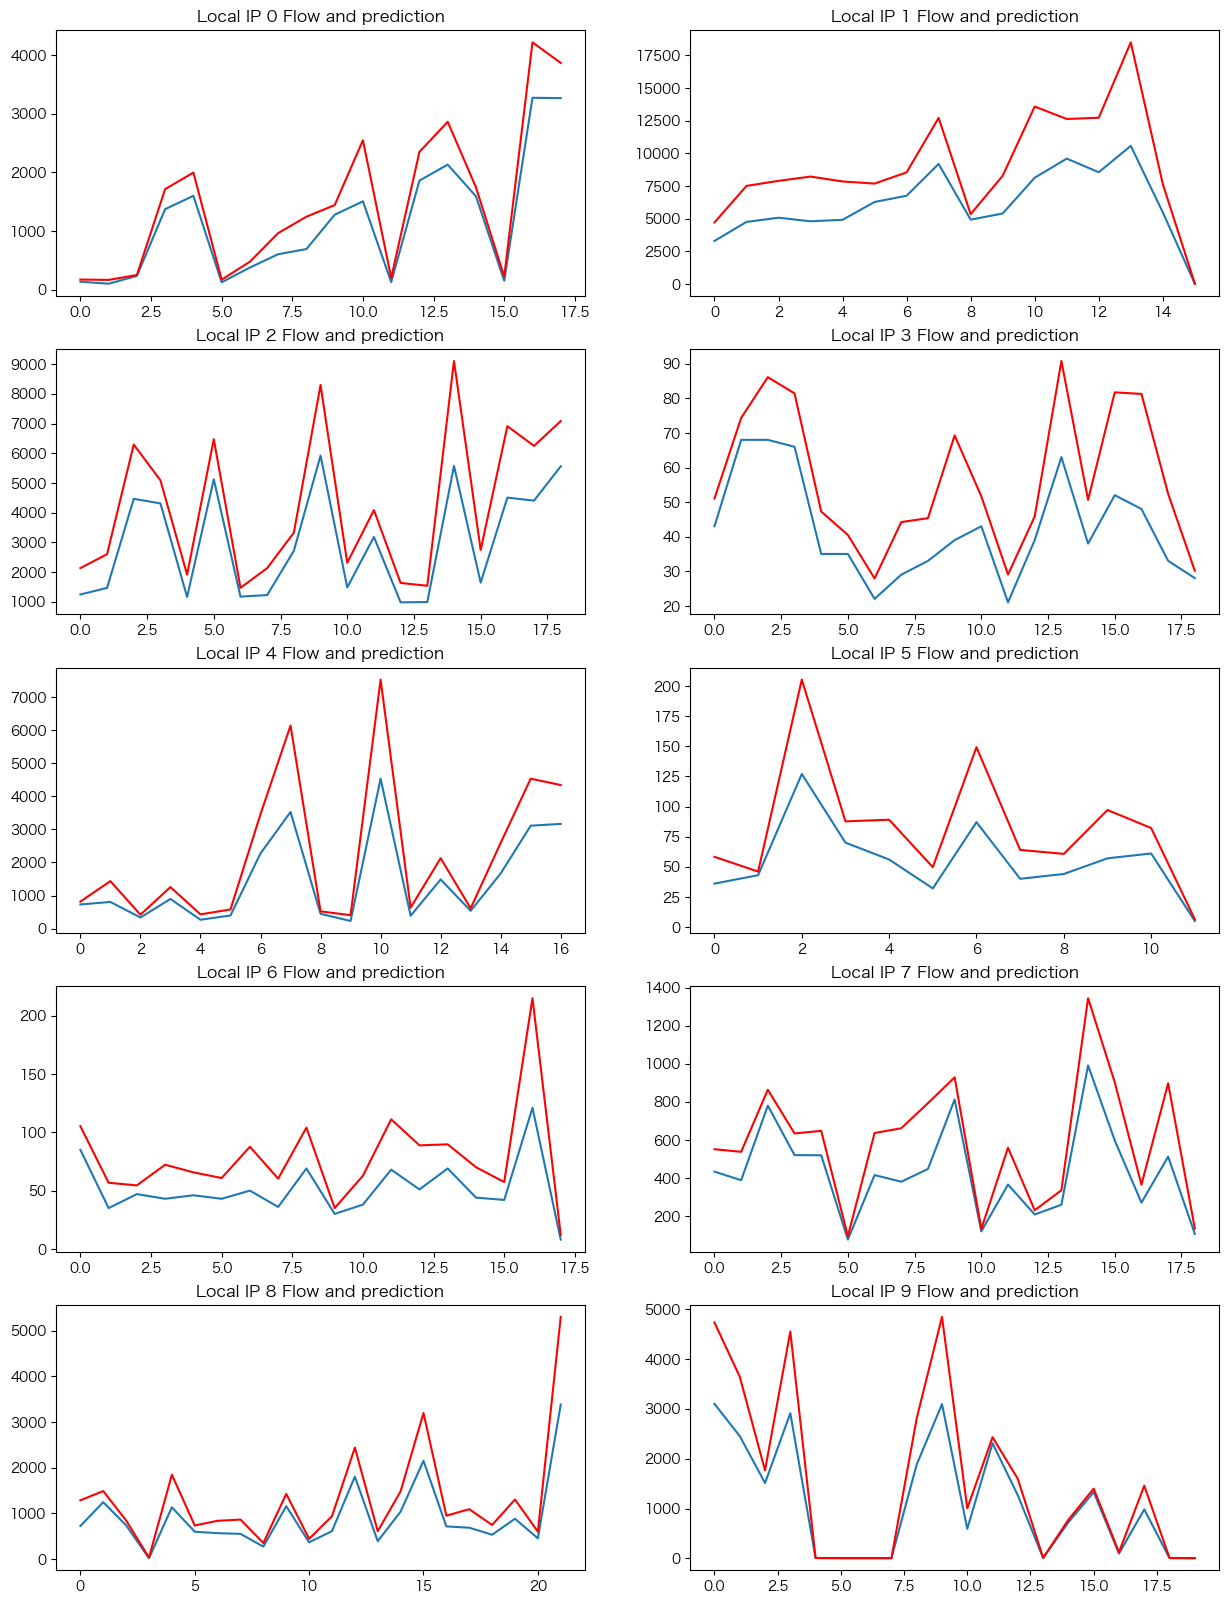

In [44]:
f,axarray = plt.subplots(5,2,figsize=(15,20))

ypred0 = np.multiply(predictFlow(m0,ip0_test[['f','wday']].copy()),max0)
ip0f = np.multiply(ip0_test['f'],max0)
ypred0 = process1(ip0f)
ypred1 = np.multiply(predictFlow(m1,ip1_test[['f','wday']].copy()),max1)
ip1f = np.multiply(ip1_test['f'],max1)
ypred1 = process1(ip1f)
ypred2 = np.multiply(predictFlow(m2,ip2_test[['f','wday']].copy()),max2)
ip2f = np.multiply(ip2_test['f'],max2)
ypred2 = process1(ip2f)

ypred3 = np.multiply(predictFlow(m3,ip3_test[['f','wday']].copy()),max3)
ip3f = np.multiply(ip3_test['f'],max3)
ypred3 = process1(ip3f)
ypred4 = np.multiply(predictFlow(m4,ip4_test[['f','wday']].copy()),max4)
ip4f = np.multiply(ip4_test['f'],max4)
ypred4 = process1(ip4f)
ypred5 = np.multiply(predictFlow(m5,ip5_test[['f','wday']].copy()),max5)
ip5f = np.multiply(ip5_test['f'],max5)
ypred5 = process1(ip5f)

ypred6 = np.multiply(predictFlow(m6,ip6_test[['f','wday']].copy()),max6)
ip6f = np.multiply(ip6_test['f'],max6)
ypred6 = process1(ip6f)
ypred7 = np.multiply(predictFlow(m7,ip7_test[['f','wday']].copy()),max7)
ip7f = np.multiply(ip7_test['f'],max7)
ypred7 = process1(ip7f)
ypred8 = np.multiply(predictFlow(m8,ip8_test[['f','wday']].copy()),max8)
ip8f = np.multiply(ip8_test['f'],max8)
ypred8 = process1(ip8f)
ypred9 = np.multiply(predictFlow(m9,ip9_test[['f','wday']].copy()),max9)
ip9f = np.multiply(ip9_test['f'],max9)
ypred9 = process1(ip9f)


axarray[0,0].plot(ip0f)
axarray[0,0].plot(ypred0,color='r')
axarray[0,0].set_title("Local IP 0 Flow and prediction")

axarray[0,1].plot(ip1f)
axarray[0,1].plot(ypred1,color='r',alpha=1)
axarray[0,1].set_title("Local IP 1 Flow and prediction")

axarray[1,0].plot(ip2f)
axarray[1,0].plot(ypred2,color='r',alpha=1)
axarray[1,0].set_title("Local IP 2 Flow and prediction")

axarray[1,1].plot( ip3f)
axarray[1,1].plot(ypred3,color='r',alpha=1)
axarray[1,1].set_title("Local IP 3 Flow and prediction")

axarray[2,0].plot( ip4f)
axarray[2,0].plot(ypred4,color='r',alpha=1)
axarray[2,0].set_title("Local IP 4 Flow and prediction")

axarray[2,1].plot(ip5f)
axarray[2,1].plot(ypred5,color='r',alpha=1)
axarray[2,1].set_title("Local IP 5 Flow and prediction")

axarray[3,0].plot(ip6f)
axarray[3,0].plot(ypred6,color='r',alpha=1)
axarray[3,0].set_title("Local IP 6 Flow and prediction")

axarray[3,1].plot(ip7f)
axarray[3,1].plot(ypred7,color='r',alpha=1)
axarray[3,1].set_title("Local IP 7 Flow and prediction")

axarray[4,0].plot(ip8f)
axarray[4,0].plot(ypred8,color='r',alpha=1)
axarray[4,0].set_title("Local IP 8 Flow and prediction")

axarray[4,1].plot(ip9f)
axarray[4,1].plot(ypred9,color='r',alpha=1)
axarray[4,1].set_title("Local IP 9 Flow and prediction")
plt.show()

In [45]:
corr0 = pd.Series(ip0f).corr(pd.Series(ypred0))
corr1 = pd.Series(ip1f).corr(pd.Series(ypred1))
corr2 = pd.Series(ip2f).corr(pd.Series(ypred2))
corr3 = pd.Series(ip3f).corr(pd.Series(ypred3))
corr4 = pd.Series(ip4f).corr(pd.Series(ypred4))
corr5 = pd.Series(ip5f).corr(pd.Series(ypred5))
corr6 = pd.Series(ip6f).corr(pd.Series(ypred6))
corr7 = pd.Series(ip7f).corr(pd.Series(ypred7))
corr8 = pd.Series(ip8f).corr(pd.Series(ypred8))
corr9 = pd.Series(ip9f).corr(pd.Series(ypred9))
corrdf = pd.DataFrame({'corr0':[corr0],
                       'corr1':[corr1],
                       'corr2':[corr2],
                       'corr3':[corr3],
                       'corr4':[corr4],
                       'corr5':[corr5],
                       'corr6':[corr6],
                       'corr7':[corr7],
                       'corr8':[corr8],
                       'corr9':[corr9]})
corrdf.head()

,corr0,corr1,corr2,corr3,corr4,corr5,corr6,corr7,corr8,corr9
0,0.986706,0.954996,0.978017,0.902604,0.992204,0.977812,0.957414,0.949822,0.990773,0.98493


# 4、基于近似熵（Approximate Entropy）的僵尸网络（BotNet）检测

在网络异常检测中，对流熵（Flow Entropy）的演变情况进行监测是一种有效的方法。流熵（Flow Entropy）的变化趋势可以用于检测网络流量中的异常行为。在网络监控中，流熵通常用于衡量网络流量的复杂性和随机性。当流熵发生显著变化时，这可能表示网络流量的模式发生了变化，这可能是由于正常的网络行为（如用户行为模式的改变）或异常行为（如网络攻击或故障）引起的。

以下是一些可能表示出现异常的流熵变化趋势：

* 突然增加：如果流熵值突然显著增加，这可能表示网络流量中出现了不规则或随机的模式。这可能是由于网络攻击（如拒绝服务攻击、流量放大攻击等）或网络设备的故障引起的。

* 持续上升或下降：流熵值的持续上升或下降可能表示网络流量的长期变化。如果这种变化与网络的正常行为模式不符，那么这可能是一个异常行为的迹象。例如，持续下降的流熵可能表示网络流量变得过于规律，这可能是由于某种形式的流量操纵或控制行为。

* 周期性变化：在某些情况下，正常的网络流量可能会显示出周期性变化。然而，如果这些周期性变化突然消失或出现新的周期性模式，这可能是一个异常行为的迹象。

* 尖峰或异常值：在流熵的时间序列中出现孤立的尖峰或异常值可能表示网络流量的短暂不规则性。这可能是由于网络中的短暂事件（如网络设备的重启、临时网络拥塞等）或异常行为（如短暂的DDoS攻击）引起的。

需要注意的是，仅凭流熵的变化趋势并不足以确定是否存在异常行为。为了进行有效的异常检测，通常需要结合其他监控指标、网络日志和安全事件信息来综合分析。此外，还可能需要使用机器学习或统计方法来构建异常检测模型，以更准确地识别异常行为。


此处将使用近似熵（Approximate Entropy）来评估时间序列的熵值。近似熵是一种衡量时间序列复杂性和规律性的统计工具，它有助于识别出数据中的模式或结构。在网络流量分析中，通过计算网络流量的近似熵，可以检测到异常流量模式，进而实现网络异常的检测。

In [48]:
ip0 = df[df['l_ipn']==0]
ip1 = df[df['l_ipn']==1][0:len(df[df['l_ipn']==1])-5]
ip2 = df[df['l_ipn']==2]
ip3 = df[df['l_ipn']==3]
ip4 = df[df['l_ipn']==4][0:len(df[df['l_ipn']==4])-7]
ip5 = df[df['l_ipn']==5]
ip6 = df[df['l_ipn']==6]
ip7 = df[df['l_ipn']==7]
ip8 = df[df['l_ipn']==8]
ip9 = df[df['l_ipn']==9]

## 计算近似熵的方法

In [50]:
def ApEn(U, m, r):

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m + 1) - _phi(m))

In [51]:
m=2
r = 3
e0 = ApEn(np.multiply(ip0['f'].values,1),m,r)
e1 = ApEn(np.multiply(ip1['f'].values,1),m,r)
e2 = ApEn(np.multiply(ip2['f'].values,1),m,r)
e3 = ApEn(np.multiply(ip3['f'].values,1),m,r)
e4 = ApEn(np.multiply(ip4['f'].values,1),m,r)
e5 = ApEn(np.multiply(ip5['f'].values,1),m,r)
e6 = ApEn(np.multiply(ip6['f'].values,1),m,r)
e7 = ApEn(np.multiply(ip7['f'].values,1),m,r)
e8 = ApEn(np.multiply(ip8['f'].values,1),m,r)
e9 = ApEn(np.multiply(ip9['f'].values,1),m,r)

In [52]:
ent_values = pd.DataFrame({'e0':[e0], 'e1':[e1],'e2':[e2],'e3':[e3],'e4':[e4],'e5':[e5],
              'e6':[e6],'e7':[e7],'e8':[e8],'e9':[e9]})
ent_values.head()

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
0,0.01105,0.020203,0.01105,0.360497,0.012903,0.169414,0.286478,0.004184,0.01105,0.264248


近似熵（Approximate Entropy, ApEn）的值越高，时间序列的不规则性就越大。
<br><br>
现在来看看IP流熵是如何随时间演变的。

In [54]:
def entropyTrend(data,d):
    etrend = [ApEn(np.multiply(data[n:n+d].values,1),2,3) for n in range(len(data)-d)]
    return etrend

## 绘制10台主机的近似熵变化趋势

Text(0.5, 1.0, 'Local IP 9 ApEn Variation')

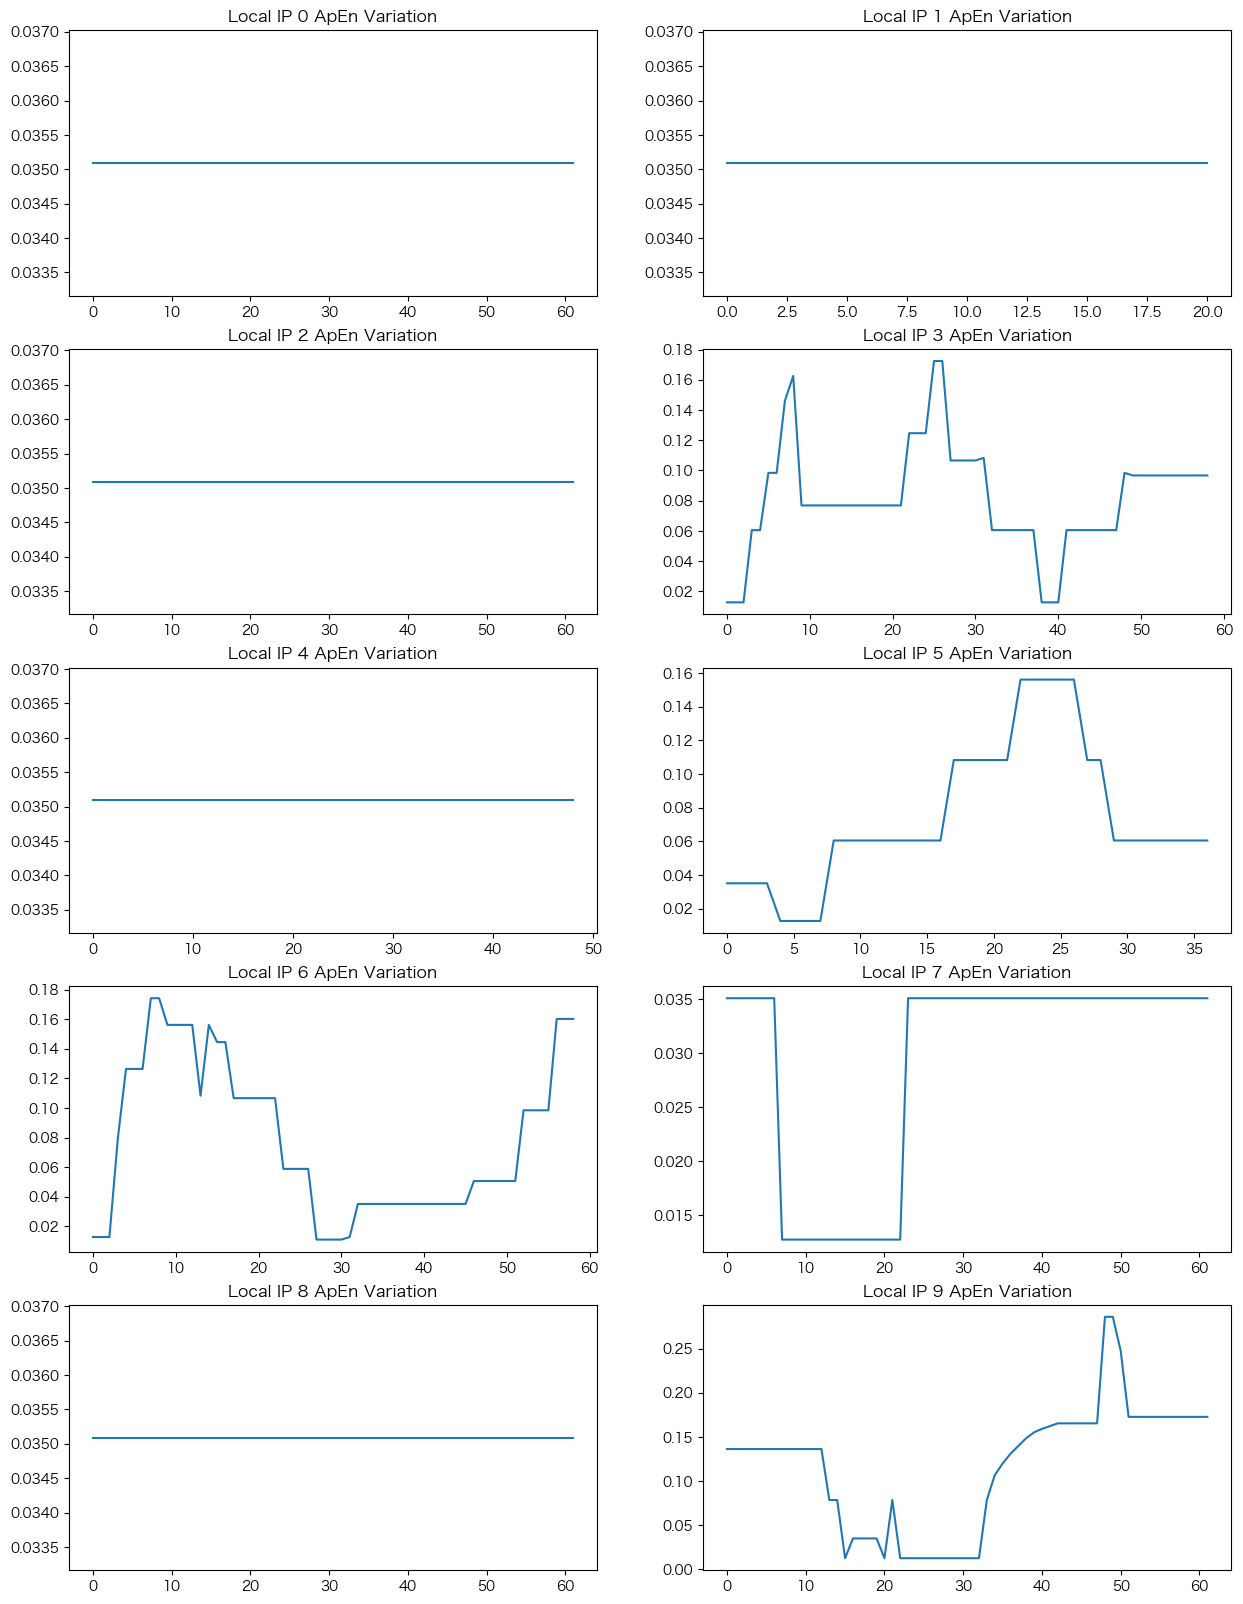

In [56]:
f,axarray = plt.subplots(5,2,figsize=(15,20))
days = 30
et0 = entropyTrend(ip0['f'],days)
axarray[0,0].plot(range(len(et0)),et0)
axarray[0,0].set_title("Local IP 0 ApEn Variation")

et1 = entropyTrend(ip1['f'],days)
axarray[0,1].plot(range(len(et1)),et1)
axarray[0,1].set_title("Local IP 1 ApEn Variation")

et2 = entropyTrend(ip2['f'],days)
axarray[1,0].plot(range(len(et2)),et2)
axarray[1,0].set_title("Local IP 2 ApEn Variation")

et3 = entropyTrend(ip3['f'],days)
axarray[1,1].plot(range(len(et3)),et3)
axarray[1,1].set_title("Local IP 3 ApEn Variation")

et4 = entropyTrend(ip4['f'],days)
axarray[2,0].plot(range(len(et4)),et4)
axarray[2,0].set_title("Local IP 4 ApEn Variation")

et5 = entropyTrend(ip5['f'],days)
axarray[2,1].plot(range(len(et5)),et5)
axarray[2,1].set_title("Local IP 5 ApEn Variation")

et6 = entropyTrend(ip6['f'],days)
axarray[3,0].plot(range(len(et6)),et6)
axarray[3,0].set_title("Local IP 6 ApEn Variation")

et7 = entropyTrend(ip7['f'],days)
axarray[3,1].plot(range(len(et7)),et7)
axarray[3,1].set_title("Local IP 7 ApEn Variation")

et8 = entropyTrend(ip8['f'],days)
axarray[4,0].plot(range(len(et8)),et8)
axarray[4,0].set_title("Local IP 8 ApEn Variation")

et9 = entropyTrend(ip9['f'],days)
axarray[4,1].plot(range(len(et9)),et9)
axarray[4,1].set_title("Local IP 9 ApEn Variation")